# Advanced Econometrics: Group Assignment 1

## Students of Group 5

Yi-Pei Siao, 2872991, y.p.siao@student.vu.nl;
Sofia Jeong, 2894452, e.jeong@student.vu.nl;
Avril Rodriguez, 2903029, a.v.rodriguez@student.vu.nl;
Pepijn Bouwman, 2892824, p.bouwman2@student.vu.nl

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import warnings
# !pip install numdifftools
import numdifftools as nd

from scipy.optimize import minimize
from scipy.stats import t as student_t

np.random.seed(42)

# --- I/O settings ---
DATA_FILE = "crsp_data.csv"
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Question 2

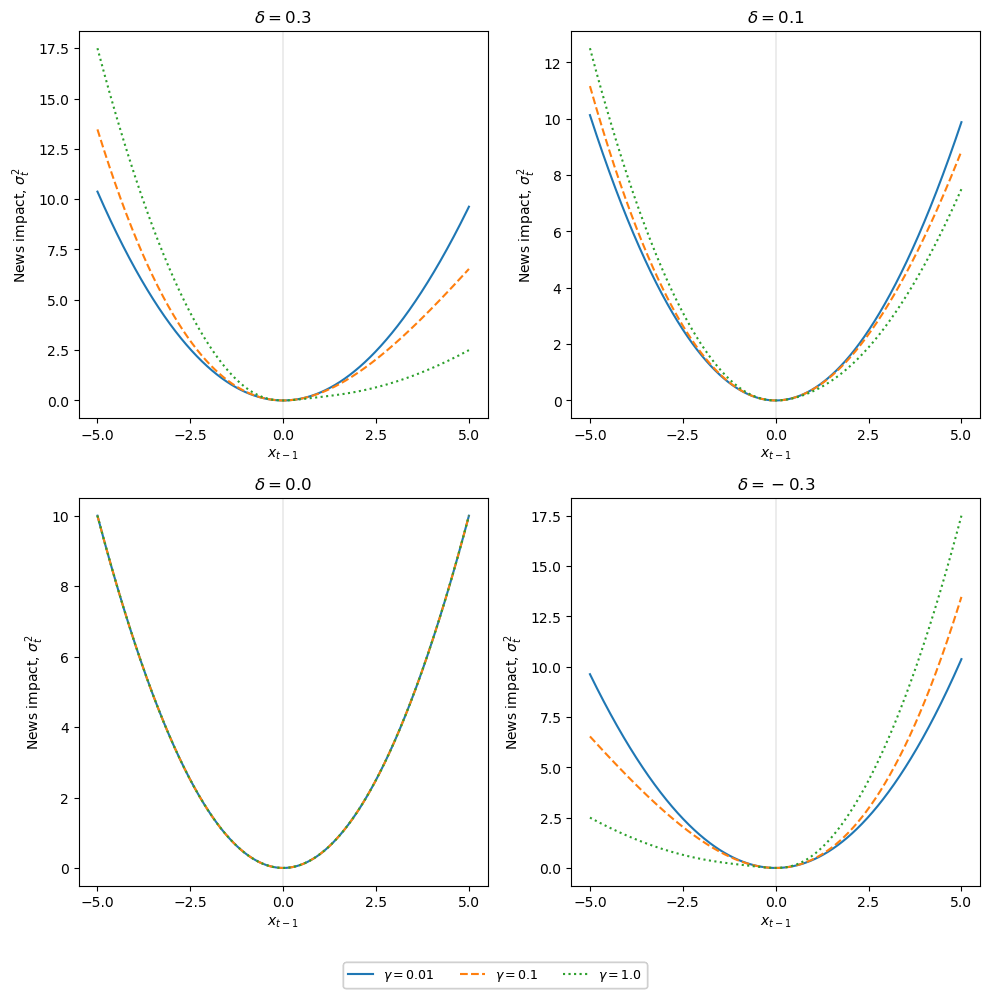

In [17]:
# --- Question 2 ---

# Given parameters and initialization
alpha = 0.4
gamma = [0.01, 0.1, 1.0]
delta = [0.3, 0.1, 0.0, -0.3]

x = np.linspace(-5, 5,1000) # X-axis
# x = np.linspace(-125, 125,1000) not visible

lines = ['-', '--', ':']

# News Impact Curve definition followed by the given parameter setting as default
def nic(x, delta, gamma, mu = 0, lam = 0, sig2_init = 1, omega = 0, beta = 0):
    NIC = omega + (alpha + delta * np.tanh(-gamma * x)) * ((x-mu-lam*sig2_init)**2/(sig2_init)) + beta * sig2_init
    return NIC

# Ploting
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

for ax, d in zip(axes, delta):
    for g, style in zip(gamma, lines):
        news_impact = nic(x, d, g)
        ax.plot(x, news_impact, linestyle=style, label=fr"$\gamma={g}$")
    ax.axvline(0, lw=0.3, alpha=0.7, color='grey')
    ax.set_xticks(np.linspace(-5, 5, 5))
    ax.set_title(fr"$\delta={d}$", fontweight="bold")
    ax.set_xlabel(r"$x_{t-1}$")
    ax.set_ylabel("News impact, $\sigma^2_{t}$")
    handles, labels = ax.get_legend_handles_labels()

    # Place legend at the bottom center
    fig.legend(handles, labels, loc="lower center", 
           bbox_to_anchor=(0.5, 0.0), ncol=len(gamma), frameon=True, fontsize=9)

fig.tight_layout(rect=[0, 0.05, 1, 1]) 

# fig.suptitle(r"News impact curves for the GARCH-M-L model $(\mu=0$, $\lambda=0$, $\alpha=0.4$, $\sigma^2_{t-1}=1)$", fontsize=14)
plt.show()
fig.savefig(os.path.join(OUT_DIR, "Q2_NIC_plots.png"), dpi=400, bbox_inches="tight")
fig.savefig(os.path.join(OUT_DIR, "Q2_NIC_plots.pdf"), bbox_inches="tight")

# Question 3

Saved: outputs/Q3_d_stats.csv
Saved: outputs/Q3_d_stats.tex

AAPL check (Mean, Std. Dev., Min, Max):
Mean          0.1071
Std. Dev.     1.7832
Min         -12.8647
Max          11.9808


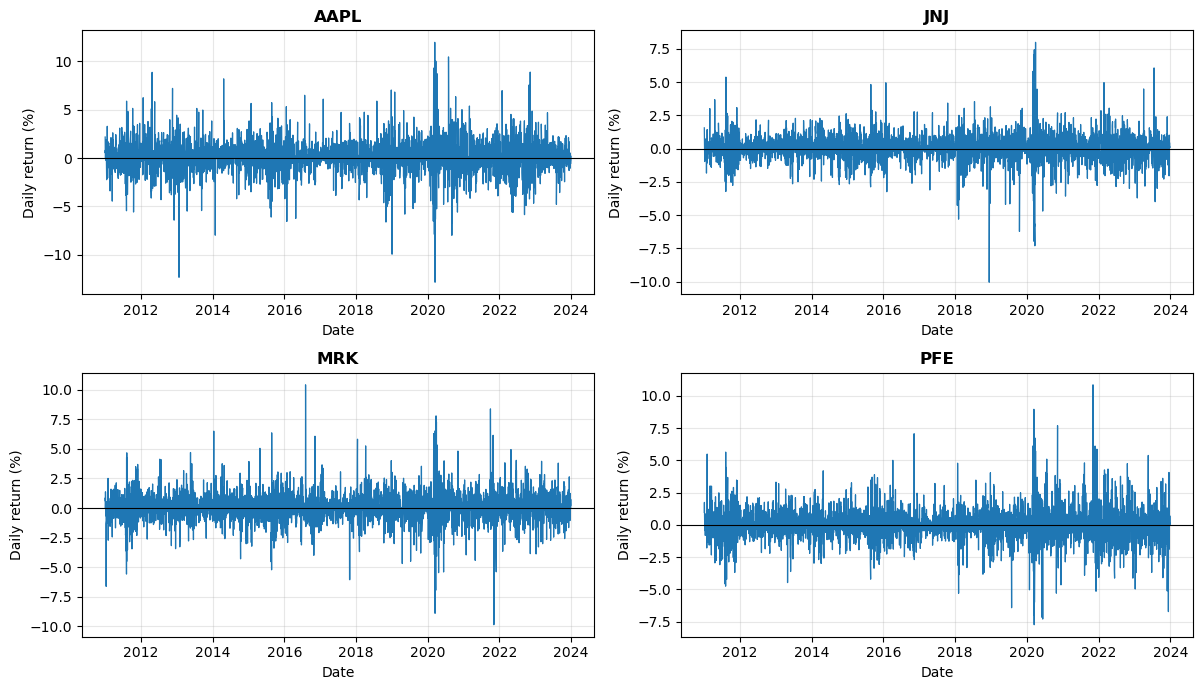

In [15]:
# --- Question 3 ---

# Load data
df = pd.read_csv(DATA_FILE)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Scale returns 
df["RET"] = df["RET"] * 100

# Descriptive statistics per ticker
def describe_series(x: pd.Series) -> dict:
    x = x.dropna()
    return {
        "N": int(x.shape[0]),
        "Mean": x.mean(),
        "Median": x.median(),
        "Std. Dev.": x.std(ddof=1),
        "Skewness": x.skew(),
        "Excess Kurtosis": x.kurt(),  # excess kurtosis
        "Min": x.min(),
        "Max": x.max(),
    }

stats_rows = []
for tkr, g in df.groupby("TICKER", sort=True):
    stats_rows.append(pd.Series(describe_series(g["RET"]), name=tkr))

stats_df = pd.DataFrame(stats_rows)
stats_df = stats_df[["N","Mean","Median","Std. Dev.","Skewness","Excess Kurtosis","Min","Max"]]

# Rounded copy for reporting
stats_rounded = stats_df.copy()
stats_rounded[["Mean","Median","Std. Dev.","Skewness","Excess Kurtosis","Min","Max"]] = \
    stats_rounded[["Mean","Median","Std. Dev.","Skewness","Excess Kurtosis","Min","Max"]].round(4)

# Save outputs
stats_rounded.to_csv(os.path.join(OUT_DIR, "Q3_d_stats.csv"))
with open(os.path.join(OUT_DIR, "Q3_d_stats.tex"), "w") as f:
    f.write(
        stats_rounded.to_latex(
            caption="Descriptive statistics of daily holding period returns (in %).",
            label="tab:Q3_desc_stats",
            index=True,
            escape=False
        )
    )

print("Saved:", os.path.join(OUT_DIR, "Q3_d_stats.csv"))
print("Saved:", os.path.join(OUT_DIR, "Q3_d_stats.tex"))

# Check Apple values
check = stats_df.loc["AAPL", ["Mean", "Std. Dev.", "Min", "Max"]].round(4)
print("\nAAPL check (Mean, Std. Dev., Min, Max):")
print(check.to_string())


# Plots on 2x2 panel
tickers = ["AAPL", "JNJ", "MRK", "PFE"]
df_plot = df.dropna(subset=["date", "RET"]).copy()

fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=False, sharey=False)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(tickers) and tickers[i] in df_plot["TICKER"].unique():
        tkr = tickers[i]
        sub = df_plot[df_plot["TICKER"] == tkr].sort_values("date")
        ax.plot(sub["date"], sub["RET"], linewidth=0.9, label=f"{tkr}")
        ax.axhline(0, linewidth=0.8, color="black")
        ax.grid(alpha=0.3)
        ax.set_title(tkr, fontweight="bold")
        ax.set_xlabel("Date")
        ax.set_ylabel("Daily return (%)")
        ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # tick every 2 years
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    else:
        ax.axis("off")


fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "Q3_returns_plots.png"), dpi=200, bbox_inches="tight")
fig.savefig(os.path.join(OUT_DIR, "Q3_returns_plots.pdf"), bbox_inches="tight")

# Question 4

In [ ]:
# Define negative log-likelihood functions for each GARCH model

def neg_logL_GARCH(params, x):
    mu, omega, alpha, beta, nu = params
    T = x.size

    if alpha < 0 or omega <= 0 or beta < 0 or nu <= 2.001:
        return 1e12

    # if alpha + beta >= 0.9999:
    #     return 1e10 + 1e8 * (alpha + beta - 0.9999)

    sigma_sqrd = np.zeros(T)
    sigma_sqrd[0] = np.average((x[:50] - np.average(x[:50]))**2)

    for t in range(1, T):
        resid_prev = (x[t-1] - mu) / np.sqrt(np.maximum(sigma_sqrd[t-1], 1e-12))
        sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]

        if not np.isfinite(sigma_sqrd[t]) or sigma_sqrd[t] <= 0:
            return 1e12

    epsilon = (x - mu) / np.sqrt(sigma_sqrd)

    log_pdf = (
        math.lgamma((nu + 1) / 2)
        - 0.5 * np.log(nu * np.pi)
        - math.lgamma(nu / 2)
        - ((nu + 1) / 2) * np.log(1 + epsilon**2 / nu)
    )

    logL = np.sum(log_pdf - 0.5 * np.log(sigma_sqrd))
    return -logL

def neg_logL_GARCH_M(params, x):
    mu, lam, omega, alpha, beta, nu = params
    T = x.size

    if alpha < 0 or omega <= 0 or beta < 0 or nu <= 2.001:
        return 1e12

    # if alpha + beta >= 0.9999:
    #     return 1e10 + 1e8 * (alpha + beta - 0.9999)

    sigma_sqrd = np.zeros(T)
    sigma_sqrd[0] = np.average((x[:50] - np.average(x[:50]))**2)

    for t in range(1, T):
        cond_mean = mu + lam * sigma_sqrd[t-1]
        resid_prev = (x[t-1] - cond_mean) / np.sqrt(np.maximum(sigma_sqrd[t-1], 1e-12))
        sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]

        if not np.isfinite(sigma_sqrd[t]) or sigma_sqrd[t] <= 0:
            return 1e12

    epsilon = (x - (mu + lam * sigma_sqrd)) / np.sqrt(sigma_sqrd)

    log_pdf = (
        math.lgamma((nu + 1) / 2)
        - 0.5 * np.log(nu * np.pi)
        - math.lgamma(nu / 2)
        - ((nu + 1) / 2) * np.log(1 + epsilon**2 / nu)
    )

    logL = np.sum(log_pdf - 0.5 * np.log(sigma_sqrd))
    return -logL

def neg_logL_GARCH_M_L(params, x):
    mu, lam, omega, alpha, delta, gamma, beta, nu = params
    T = x.size

    if alpha < 0 or omega <= 0 or beta < 0 or nu <= 2.001 or gamma <= 0:
        return 1e12

    # if alpha + beta >= 0.9999:
    #     return 1e10 + 1e8 * (alpha + beta - 0.9999)

    if alpha <= abs(delta):
        return 1e10 + 1e8 * (abs(delta) - alpha)

    sigma_sqrd = np.zeros(T)
    sigma_sqrd[0] = np.average((x[:50] - np.average(x[:50]))**2)

    for t in range(1, T):
        cond_mean = mu + lam * sigma_sqrd[t-1]
        resid_prev = (x[t-1] - cond_mean) / np.sqrt(np.maximum(sigma_sqrd[t-1], 1e-6))
        arch_coeff = alpha + delta * np.tanh(-gamma * x[t-1])
        sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]

        if not np.isfinite(sigma_sqrd[t]) or sigma_sqrd[t] <= 0:
            return 1e12

    epsilon = (x - (mu + lam * sigma_sqrd)) / np.sqrt(sigma_sqrd)

    log_pdf = (
        math.lgamma((nu + 1) / 2)
        - 0.5 * np.log(nu * np.pi)
        - math.lgamma(nu / 2)
        - ((nu + 1) / 2) * np.log(1 + epsilon**2 / nu)
    )

    logL = np.sum(log_pdf - 0.5 * np.log(sigma_sqrd))
    return -logL + 0.001 * gamma**2


In [ ]:
# Check if log-likelihood is correct w/ givenn optimal parameters

test_params_GARCH = [
    0.154 ,    # mu
    0.038,     # omega
    0.090,     # alpha
    0.873,     # beta
    4.146      # nu
]

test_params_GARCH_M = [
    0.072,     # mu
    0.061,     # lam
    0.037,     # omega
    0.089,     # alpha
    0.875,     # beta
    4.138      # nu
]

test_params_GARCH_M_L = [
    0.108,     # mu
    0.022,     # lam
    0.012,     # omega
    0.073,     # alpha
    0.071,     # delta
    0.439,     # gamma
    0.915,     # beta
    4.402      # nu
]

# Get your data
ret_AAPL = df[df['TICKER'] == 'AAPL']['RET'].iloc[:2500]

# Calculate the negative log-likelihood for each parameter set
nll_garch = neg_logL_GARCH(test_params_GARCH, ret_AAPL)
nll_garch_m = neg_logL_GARCH_M(test_params_GARCH_M, ret_AAPL)
nll_garch_m_l = neg_logL_GARCH_M_L(test_params_GARCH_M_L, ret_AAPL)

# Print the results
print(f"Log-Likelihood for GARCH: {-nll_garch:.0f}") # Should be -4662
print("---")
print(f"Log-Likelihood for GARCH-M: {-nll_garch_m:.0f}") # Should be -4662
print("---")
print(f"Log-Likelihood for GARCH-M-L: {-nll_garch_m_l:.0f}")

In [ ]:
# Define functions to fit each GARCH model

def fit_GARCH_model(returns, model_type, start_params, bounds):
    x = np.asarray(returns, dtype=float)
    T = x.size

    if model_type == 'GARCH':
        obj_func = neg_logL_GARCH
    elif model_type == 'GARCH-M':
        obj_func = neg_logL_GARCH_M
    elif model_type == 'GARCH-M-L':
        obj_func = neg_logL_GARCH_M_L
    else:
        raise ValueError("Invalid model type specified.")

    optim = minimize(lambda p: obj_func(p, x),
                     x0=start_params,
                     bounds=bounds,
                     method='L-BFGS-B',
                     options={'disp': False})

    param_estimates = optim.x
    H, cov, se = None, None, None
    if nd:
        try:
            hess_func = nd.Hessian(lambda p: obj_func(p, x))
            H = hess_func(param_estimates)
            cov = np.linalg.pinv(H)
            se = np.sqrt(np.maximum(np.diag(cov), 0.0))
        except Exception as e:
            warnings.warn(f"Hessian failed: {e}")

    # Re-calculate final sigma and standardized residuals using the estimated params
    final_params = param_estimates
    sigma_sqrd = np.zeros(T)
    sigma_sqrd[0] = np.average((x[:50] - np.average(x[:50]))**2)

    # Note: This block re-simulates the variance.
    if model_type == 'GARCH':
        mu, omega, alpha, beta, nu = final_params
        cond_mean = mu
        for t in range(1, T):
            resid_prev = (x[t-1] - cond_mean) / np.sqrt(sigma_sqrd[t-1])
            sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
        epsilon = (x - cond_mean) / np.sqrt(sigma_sqrd)
    elif model_type == 'GARCH-M':
        mu, lam, omega, alpha, beta, nu = final_params
        for t in range(1, T):
            cond_mean = mu + lam * sigma_sqrd[t-1]
            resid_prev = (x[t-1] - cond_mean) / np.sqrt(sigma_sqrd[t-1])
            sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
        epsilon = (x - (mu + lam * sigma_sqrd)) / np.sqrt(sigma_sqrd)
    elif model_type == 'GARCH-M-L':
        mu, lam, omega, alpha, delta, gamma, beta, nu = final_params
        for t in range(1, T):
            cond_mean = mu + lam * sigma_sqrd[t-1]
            resid_prev = (x[t-1] - cond_mean) / np.sqrt(sigma_sqrd[t-1])
            arch_coeff = alpha + delta * np.tanh(-gamma * x[t-1])
            sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
        epsilon = (x - (mu + lam * sigma_sqrd)) / np.sqrt(sigma_sqrd)
    else:
        raise ValueError("Invalid model type specified.")

    logL = -optim.fun
    k = len(param_estimates)

    result = {
        'params': param_estimates,
        'se': se,
        'cov': cov,
        'hess': H,
        'nll': optim.fun,
        'success': optim.success,
        'message': optim.message,
        'fitted_sigma2': sigma_sqrd,
        'std_resid': epsilon,
        'df': T,
        'logL': logL,
        'AIC': 2*k - 2*logL,
        'BIC': k*np.log(T) - 2*logL
    }
    return result

In [ ]:
def print_results(results_dict, model_type):

    print("="*60)
    print(f"RESULTS FOR THE {model_type.upper()} MODEL")
    print("="*60)

    # Check if the optimization was successful
    if not results_dict['success']:
        print(f"Warning: Optimization failed. Message: {results_dict['message']}\n")

    # Define parameter names based on the model type
    if model_type == 'GARCH':
        param_names = ['mu', 'omega', 'alpha', 'beta', 'nu']
    elif model_type == 'GARCH-M':
        param_names = ['mu', 'lam', 'omega', 'alpha', 'beta', 'nu']
    elif model_type == 'GARCH-M-L':
        param_names = ['mu', 'lam', 'omega', 'alpha', 'delta', 'gamma', 'beta', 'nu']
    else:
        param_names = [] # Fallback for unknown model types

    # Create a table for parameters and standard errors
    params = results_dict['params']
    se = results_dict['se']

    if se is not None and len(se) == len(params):
        param_table = pd.DataFrame({
            'Parameter': results_dict['params'],
            'Standard Error': results_dict['se']
        })
        param_table.index = param_names
        print("\n-------Parameter  Estimates-------")
        print(param_table.to_string(float_format="%.3f"))

    else:
        print("\n-------Parameter  Estimates-------")
        for name, value in zip(param_names, params):
            print(f"  {name: <10}: {value: .3f}")

    print("\n------Goodness of Fit Metrics------")
    print(f"  Negative Log-Likelihood: {results_dict['nll']:.3f}")
    print(f"  Log-Likelihood: {results_dict['logL']:.3f}")
    print(f"  AIC (Akaike Information Criterion): {results_dict['AIC']:.3f}")
    print(f"  BIC (Bayesian Information Criterion): {results_dict['BIC']:.3f}")

    print("="*60)

In [ ]:
# Define bounds for each model
bounds_GARCH = [
    (-2.0, 2.0),     # mu
    (1e-6, None),    # omega
    (1e-6, 0.95),    # alpha
    (1e-6, 0.999),   # beta
    (2.05, 50.0)     # nu
]

bounds_GARCH_M = [
    (-2.0, 2.0),     # mu
    (-0.2, 0.2),     # lambda
    (1e-6, None),    # omega
    (1e-6, 0.95),    # alpha
    (1e-6, 0.999),   # beta
    (2.05, 50.0)     # nu
]

bounds_GARCH_M_L = [
    (-2.0, 2.0),     # mu
    (-0.2, 0.2),     # lambda  (first pass)
    (1e-6, None),    # omega
    (1e-6, 0.95),    # alpha
    (-1.0, 1.0),     # delta
    (1e-6, 20.0),    # gamma   (20 already saturates over |x|<=5)
    (1e-6, 0.999),   # beta
    (2.05, 50.0)     # nu
]

In [ ]:
# Lists of tickers, model types, start parameters, and bounds

tickers_to_fit = ['MRK', 'AAPL','PFE', 'JNJ' ]
model_types = ['GARCH', 'GARCH-M', 'GARCH-M-L']
bounds_list = [bounds_GARCH, bounds_GARCH_M, bounds_GARCH_M_L]

results = {}
par_results = {}
# Loop over tickers and model type

for ticker in tickers_to_fit:
  print("=" * 60)
  print(f"\nFITTING MODELS FOR TICKER: {ticker}\n")
  print("=" * 60)

  ret_per_ticker = df[df['TICKER'] == ticker]['RET'].iloc[:2500]
  sample_var = np.var(ret_per_ticker)

  start_param_GARCH = [
      0,                 # mu
      sample_var / 50,   # omega
      0.05,              # alpha
      0.9,               # beta
      10                 # nu
  ]

  start_param_GARCH_M = [
      0,                 # mu
      0,                 # lambda
      sample_var / 50,   # omega
      0.05,              # alpha
      0.9,               # beta
      10                 # nu
  ]

  start_param_GARCH_M_L = [
      0,                 # mu
      0,                 # lambda
      sample_var / 50,   # omega
      0.05,              # alpha
      0.01,              # delta
      0.01,              # gamma
      0.9,               # beta
      10                 # nu
  ]

  model_fit_list = []
  start_params_list = [start_param_GARCH, start_param_GARCH_M, start_param_GARCH_M_L]
  par_results[ticker] = {}
  for model_type, start_params, bounds in zip(model_types, start_params_list, bounds_list):
      results = fit_GARCH_model(ret_per_ticker, model_type, start_params, bounds)
      model_fit_list.append(results)
      par_results[ticker][model_type] = results['params']
      print_results(results, model_type)

results[ticker] = model_fit_list

# Question 5

In [ ]:
# --- Question 5 --- 
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# Load data
DF = pd.read_csv("crsp_data.csv")
DF.columns = DF.columns.str.lower()
DF["date"] = pd.to_datetime(DF["date"])
DF = DF.sort_values(["ticker","date"])

# Residual Diagnostics Helper
def ljung_box(resid, lags=20):
    lb1 = acorr_ljungbox(resid, lags=lags, return_df=True)
    lb2 = acorr_ljungbox(resid**2, lags=lags, return_df=True)
    return (
        lb1["lb_stat"].iloc[-1], lb1["lb_pvalue"].iloc[-1],
        lb2["lb_stat"].iloc[-1], lb2["lb_pvalue"].iloc[-1]
    )

def arch_lm(resid, L=10):
    z2 = resid**2
    y = z2[L:]
    X = np.column_stack([z2[L-i-1:-i-1] for i in range(L)])
    X = np.column_stack([np.ones(len(X)), X])  
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    yhat = X @ beta
    ss_tot = ((y - y.mean())**2).sum()
    ss_res = ((y - yhat)**2).sum()
    R2 = 0.0 if ss_tot <= 0 else 1 - ss_res/ss_tot
    T = len(y)
    stat = T * R2
    p = 1 - stats.chi2.cdf(stat, df=L)
    return stat, p

def jarque_bera(resid):
    JB, p = stats.jarque_bera(resid)
    return JB, p

def persistence_half_life(alpha, beta):
    phi = alpha + beta
    hl = np.inf if (phi <= 0 or phi >= 1) else np.log(0.5)/np.log(phi)
    return phi, hl

# sigma_t^2 & Standardized Residuals ----------
def build_sigma2_series(x, sigma1_sq, model, params):
    """
    model: 'GARCH' | 'GARCH-M' | 'GARCH-M-L'
    params keys:
      mu, omega, alpha, beta, [lam], [delta], [gamma]
    """
    n = len(x)
    sigma2 = np.empty(n, dtype=float)
    sigma2[0] = max(sigma1_sq, 1e-10)

    mu    = float(params.get("mu", 0.0))
    lam   = float(params.get("lam", 0.0))
    omega = float(params["omega"])
    alpha = float(params["alpha"])
    beta  = float(params["beta"])
    delta = float(params.get("delta", 0.0))
    gamma = float(params.get("gamma", 0.0))

    for t in range(1, n):
        lever = 0.0
        if model == "GARCH-M-L":
            lever = delta * x[t-1] + gamma * (1.0 if x[t-1] >= 0 else -1.0) * x[t-1]
        sigma2[t] = omega + alpha*(x[t-1]**2) + beta*sigma2[t-1] + lever
        if sigma2[t] <= 0:
            sigma2[t] = 1e-10  

    sigma = np.sqrt(sigma2)
    z = (x - mu - lam*sigma2) / sigma
    return sigma2, z

# ---------- main ----------
def run_q5_for_ticker(df, ticker, n_obs=2500, lb_lags=20, lm_lags=10,
                      model="GARCH-M-L", params=None,
                      assume_params_in_percent=False): # False = percentage
    x = df[df["ticker"]==ticker]["ret"].dropna().values[:n_obs]

    # initial: first 50 (/n）
    init = x[:50]
    sigma1_sq = ((init - init.mean())**2).mean()

    if params is None:
        raise ValueError("Need params（according to question 4）")

    p = params.copy()
    if assume_params_in_percent:
        for key in ["mu","lam","delta","gamma"]:
            if key in p:
                p[key] = p[key] / 100.0

    sigma2_hat, z = build_sigma2_series(x, sigma1_sq, model, p)

    # test
    Qz, pz, Qz2, pz2 = ljung_box(z, lags=lb_lags)
    LM, pLM = arch_lm(z, L=lm_lags)
    JB, pJB = jarque_bera(z)
    phi, HL = persistence_half_life(p["alpha"], p["beta"])

    out = {
        "Ticker": ticker,
        "Model": model,
        "LB(z)_stat": Qz,   "LB(z)_p": pz,
        "LB(z2)_stat": Qz2, "LB(z2)_p": pz2,
        "ARCH-LM_stat": LM, "ARCH-LM_p": pLM,
        "JB_stat": JB,      "JB_p": pJB,
        "alpha+beta": phi,  "Half-life_days": HL
    }
    return out, sigma2_hat, z

# ---------- The optimal model parameters from Q4 ----------
BEST = {
    "PFE":  {"model":"GARCH-M-L", "params":{"mu":-0.045, "lam":0.122, "omega":0.000, "alpha":0.044, "beta":0.920, "delta":0.027, "gamma":17.124}},
    "JNJ":  {"model":"GARCH-M-L", "params":{"mu":0.033,  "lam":0.063, "omega":0.003, "alpha":0.026, "beta":0.916, "delta":0.017, "gamma":1.229}},
    "MRK":  {"model":"GARCH-M",   "params":{"mu":0.077,  "lam":0.065, "omega":0.015, "alpha":0.040, "beta":0.904}},
    "AAPL": {"model":"GARCH-M-L", "params":{"mu":0.096,  "lam":0.027, "omega":0.023, "alpha":0.069, "beta":0.911, "delta":0.061, "gamma":10.474}},
}

ASSUME_PCT = False

# ---------- Batch run for four stocks, export results to CSV ----------
rows = []
STORE = {}  # # Store each stock’s (sigma², z) for Q6 plotting
for tkr, spec in BEST.items():
    out, s2, z = run_q5_for_ticker(
        DF, tkr, n_obs=2500, lb_lags=20, lm_lags=10,
        model=spec["model"], params=spec["params"],
        assume_params_in_percent=ASSUME_PCT
    )
    rows.append(out)
    STORE[tkr] = {"sigma2": s2, "z": z}

diag_df = pd.DataFrame(rows)
diag_df_rounded = diag_df.copy()
num_cols = [c for c in diag_df.columns if c not in ["Ticker","Model"]]
diag_df_rounded[num_cols] = diag_df_rounded[num_cols].astype(float).round(4)
print(diag_df_rounded)

diag_df_rounded.to_csv("q5_diagnostics.csv", index=False)
print("Saved: q5_diagnostics.csv")


/var/folders/6d/zgl67_1s53j6pwbqc54vrnlw0000gn/T/ipykernel_28354/2558361592.py:203: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


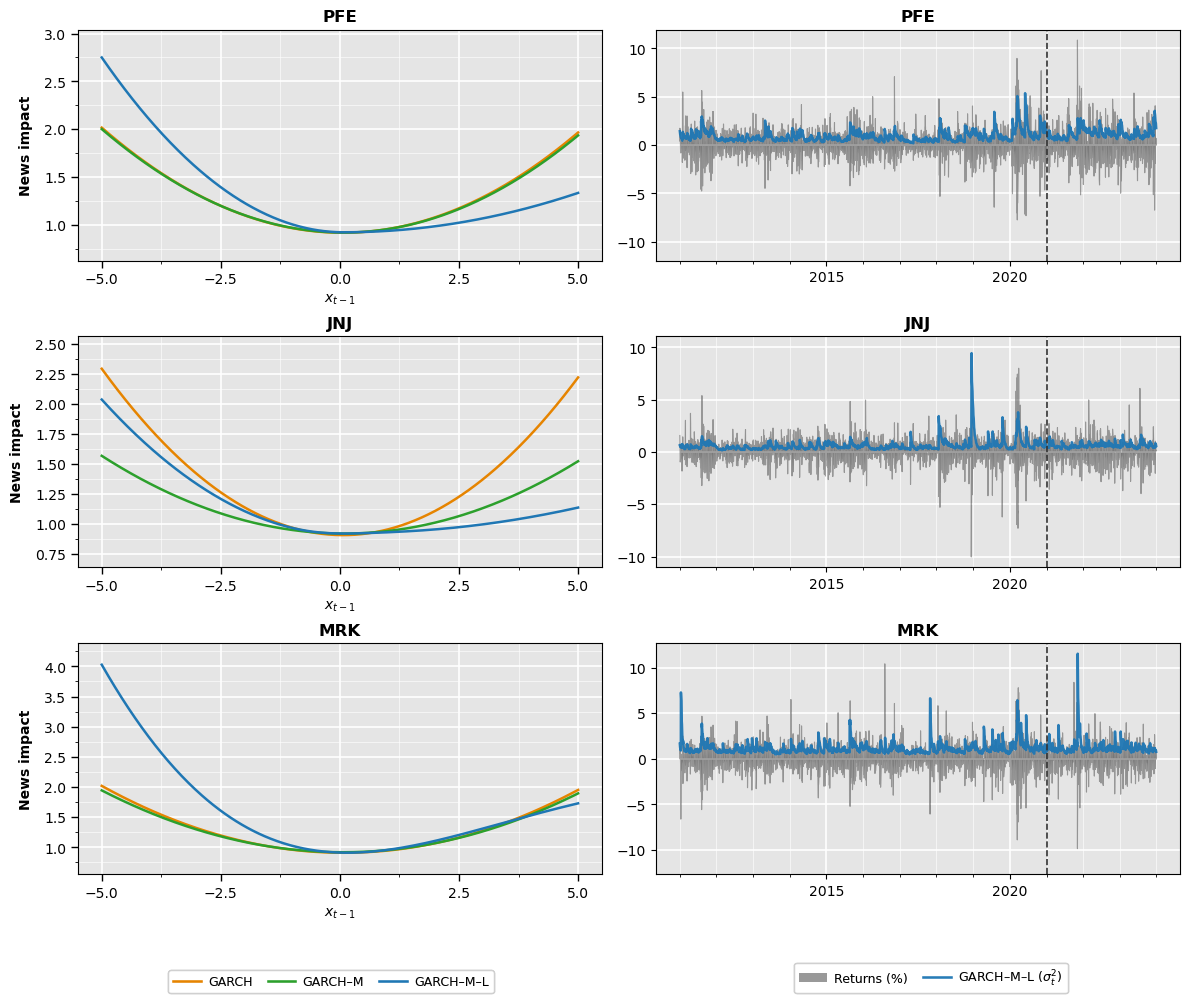

Saved: fig_q5_panel.pdf and fig_q5_panel.png


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

RETURNS_CSV = "crsp_data.csv"

# 2) In-sample cutoff (after the first 2,500 obs in the assignment).
IN_SAMPLE_CUTOFF_DATE = "2021-01-04"

# 3) Q4 parameter estimates
#    Put None for irrelevant fields (e.g., lam for GARCH is 0; delta,gamma for models w/o leverage are 0).
#    Stock tickers MUST be 'PFE','JNJ','MRK' (AAPL not required in Q5).
PARAMS = {
    "PFE": {
        "GARCH":     dict(mu=0.059, lam=0.0,   omega=0.000, alpha=0.043, beta=0.915, delta=0.0,   gamma=0.0,   nu=4.659),
        "GARCH-M":   dict(mu=0.019, lam=0.060, omega=0.000, alpha=0.042, beta=0.917, delta=0.0,   gamma=0.0,   nu=4.662),
        "GARCH-M-L": dict(mu=-0.045,lam=0.122, omega=0.000, alpha=0.044, beta=0.920, delta=0.027, gamma=17.124,nu=4.903),
    },
    "JNJ": {
        "GARCH":     dict(mu=0.067, lam=0.0,   omega=0.002, alpha=0.054, beta=0.904, delta=0.0,   gamma=0.0,   nu=9.941),
        "GARCH-M":   dict(mu=0.058, lam=0.032, omega=0.000, alpha=0.025, beta=0.919, delta=0.0,   gamma=0.0,   nu=4.387),
        "GARCH-M-L": dict(mu=0.033, lam=0.063, omega=0.003, alpha=0.026, beta=0.916, delta=0.017, gamma=1.029, nu=4.557),
    },
    "MRK": {
        "GARCH":     dict(mu=0.078, lam=0.0,   omega=0.078, alpha=0.043, beta=0.832, delta=0.0,   gamma=0.0,   nu=4.763),
        "GARCH-M":   dict(mu=0.077, lam=-0.015,omega=0.015, alpha=0.040, beta=0.904, delta=0.0,   gamma=0.0,   nu=4.502),
        "GARCH-M-L": dict(mu=0.094, lam=0.065, omega=0.044, alpha=0.076, beta=0.867, delta=0.076, gamma=0.121, nu=9.977),
    },
}

# 4) X-range (in percent) for news-impact curves (assignment example uses ~[-5,5])
X_MIN, X_MAX, X_N = -5.0, 5.0, 501

# ========================= MODEL FUNCTIONS =========================

def news_impact_sigma2(x_grid, p):
    """
    News-impact curve for model (1), holding sigma_{t-1}^2 = 1.
    sigma_t^2 = omega + (alpha + delta * tanh(-gamma * x_{t-1}))
                * ((x_{t-1} - mu - lam * sigma_{t-1}^2) / sigma_{t-1})^2
                + beta * sigma_{t-1}^2
    """
    mu    = float(p.get("mu",    0.0) or 0.0)
    lam   = float(p.get("lam",   0.0) or 0.0)
    omega = float(p.get("omega", 0.0) or 0.0)
    alpha = float(p.get("alpha", 0.0) or 0.0)
    beta  = float(p.get("beta",  0.0) or 0.0)
    delta = float(p.get("delta", 0.0) or 0.0)
    gamma = float(p.get("gamma", 0.0) or 0.0)

    sig2_prev = 1.0
    sig_prev  = 1.0
    inner = (x_grid - mu - lam*sig2_prev) / sig_prev
    mult  = alpha + delta * np.tanh(-gamma * x_grid)
    sig2  = omega + mult * (inner**2) + beta*sig2_prev
    return sig2

def filter_sigma2(x, p):
    """
    Filter conditional variances sigma_t^2 over the full sample using model (1).
    Per assignment: sigma_1^2 = population variance of first 50 returns (divide by 50, not 49).
    x must be in percent units.
    """
    mu    = float(p.get("mu",    0.0) or 0.0)
    lam   = float(p.get("lam",   0.0) or 0.0)
    omega = float(p.get("omega", 0.0) or 0.0)
    alpha = float(p.get("alpha", 0.0) or 0.0)
    beta  = float(p.get("beta",  0.0) or 0.0)
    delta = float(p.get("delta", 0.0) or 0.0)
    gamma = float(p.get("gamma", 0.0) or 0.0)

    x = np.asarray(x, dtype=float)
    T = len(x)
    if T < 60:
        raise ValueError("Not enough observations to set sigma_1^2 from first 50 returns.")

    # sigma_1^2: population variance of first 50 returns
    x50 = x[:50]
    sig2 = np.empty(T)
    sig2[0] = np.mean((x50 - x50.mean())**2)
    sig = np.sqrt(max(sig2[0], 1e-12))

    for t in range(1, T):
        inner = (x[t-1] - mu - lam*sig2[t-1]) / (sig if sig > 0 else 1e-12)
        mult  = alpha + delta * np.tanh(-gamma * x[t-1])
        sig2[t] = omega + mult * (inner**2) + beta * sig2[t-1]
        sig = np.sqrt(max(sig2[t], 1e-12))
    return sig2

# Load data
df = pd.read_csv(RETURNS_CSV)
df.columns = [c.lower() for c in df.columns]
required = {"date", "ticker", "ret"}
if not required.issubset(df.columns):
    raise ValueError(f"Returns CSV must contain columns: {required}")
df["date"] = pd.to_datetime(df["date"])
df["ticker"] = df["ticker"].str.upper()

# Keep only the three stocks required by Q5 (rows in the panel)
stocks = ["PFE", "JNJ", "MRK"]

# Plot 3×2 panel
x_grid = np.linspace(X_MIN, X_MAX, X_N)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), constrained_layout=True)

for i, s in enumerate(stocks):
    sub = df[df["ticker"] == s].sort_values("date")
    if sub.empty:
        raise ValueError(f"No rows found for ticker {s} in {RETURNS_CSV}.")
    
    from matplotlib.ticker import AutoMinorLocator

# ---------- LEFT: news-impact curves ----------
    axL = axes[i, 0]
    
    styles = {
        "GARCH":     dict(color="#E68400", linestyle="-", lw=1.8),  # orange
        "GARCH-M":   dict(color="#2ca02c", linestyle="-", lw=1.8),  # green
        "GARCH-M-L": dict(color="#1f77b4", linestyle="-", lw=1.8),  # blue
    }
    
    for model in ["GARCH", "GARCH-M", "GARCH-M-L"]:
        p = PARAMS[s][model]
        y = news_impact_sigma2(x_grid, p)
        axL.plot(x_grid, y, label=model.replace("-", "–"), **styles[model])
    
    axL.set_title(f"{s}", fontweight="bold")
    axL.set_xlabel(r"$x_{t-1}$", fontweight="bold")
    axL.set_ylabel("News impact", rotation=90, labelpad=8, fontweight="bold")
    
    # Fix X & Free Y + padding(0.2)
    axL.set_xlim(-5.2, 5.2)
    axL.relim(); axL.autoscale()
    ymin, ymax = axL.get_ylim()
    axL.set_ylim(ymin - 0.2, ymax + 0.2)
    
    axL.set_xticks(np.linspace(-5, 5, 5))
    axL.xaxis.set_minor_locator(AutoMinorLocator(2))
    axL.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    axL.set_facecolor("#E5E5E5")
    axL.grid(True, which="major", axis="both", color="white", linewidth=1.2)
    axL.grid(True, which="minor", axis="both", color="white", linewidth=0.6, alpha=0.7)
    axL.tick_params(direction="out", length=5, width=1)
    handlesL, labelsL = axes[0, 0].get_legend_handles_labels()
    fig.legend(handlesL, labelsL,
           loc="lower center",
           bbox_to_anchor=(0.28, -0.005),   
           ncol=3, frameon=True, fontsize=9,
           handlelength=2.2, handletextpad=0.6, columnspacing=1.2)

# ---------- RIGHT: filtered volatilities (GARCH-M-L) ----------
    axR = axes[i, 1]
    p_ml = PARAMS[s]["GARCH-M-L"]
    
    dates    = sub["date"].values
    rets_raw = sub["ret"].values
    rets_pct = rets_raw * 100.0 if np.nanmedian(np.abs(rets_raw)) < 2.0 else rets_raw.copy()
    sig2     = filter_sigma2(rets_pct, p_ml)
    
    axR.set_facecolor("#E5E5E5")
    
    # Returns: grey
    axR.fill_between(dates, 0.0, rets_pct, color="#636363", alpha=0.6, label="Returns (%)", linewidth=0)
    axR.plot(dates, rets_pct, color="#636363", alpha=0.6, lw=0.8)
    
    # σ²: blue line
    axR.plot(dates, sig2, lw=1.8, alpha=0.95, color="#1f77b4", label=r"GARCH–M–L ($\sigma_t^2$)")
    
    # cutoff 
    cutoff = pd.to_datetime(IN_SAMPLE_CUTOFF_DATE)
    axR.axvline(cutoff, linestyle="--", linewidth=1.2, color="0.2")
    
    axR.set_title(f"{s}", fontweight="bold")
    
    # ylim
    ylim = max(np.nanmax(np.abs(rets_pct)), np.nanmax(sig2)) * 1.10
    axR.set_ylim(-ylim, ylim)
    axR.yaxis.set_ticks_position("left")
    
    # year: every 5 years
    axR.xaxis.set_major_locator(mdates.YearLocator(base=5))
    axR.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    axR.xaxis.set_minor_locator(mdates.YearLocator())
    
    axR.grid(True, which="major", color="white", linewidth=1.2)
    axR.grid(True, which="minor", color="white", linewidth=0.6, alpha=0.7)
    handlesR, labelsR = axes[0, 1].get_legend_handles_labels()
    fig.legend(handlesR, labelsR,
           loc="lower center",
           bbox_to_anchor=(0.78, -0.005),   
           ncol=2, frameon=True, fontsize=9,
           handlelength=2.2, handletextpad=0.6, columnspacing=1.20)
    


# fig.suptitle("Q5: News-impact curves and filtered volatilities", y=1.02)

# Adjust spacing to leave room for the legends
fig.tight_layout()
fig.subplots_adjust(bottom=0.12)

# Save & show
fig.savefig("fig_q5_panel.pdf", bbox_inches="tight")
fig.savefig("fig_q5_panel.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: fig_q5_panel.pdf and fig_q5_panel.png")


# Question 6

In [ ]:
# Load data
df = pd.read_csv(DATA_FILE)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Scale returns IN MEMORY (do NOT overwrite CSV on disk)
df["RET"] = df["RET"] * 100

In [ ]:
def sigma_squared_path(ticker, model_type, target_date):

    # data
    df_date = df.loc[df['date'] <= target_date].sort_values('date')
    ret_per_ticker = df_date[df_date['TICKER'] == ticker]['RET']
    x = np.asarray(ret_per_ticker, dtype=float)
    T = x.size

    # initialize
    sigma_sqrd = np.zeros(T)
    sigma_sqrd[0] = np.average((x[:50] - np.average(x[:50]))**2)
            
    # parameters
    final_params = par_results[ticker][model_type]
    
    if model_type == 'GARCH':
        mu, omega, alpha, beta, nu = final_params
        cond_mean = mu
        for t in range(1, T):
            resid_prev = (x[t-1] - cond_mean) / np.sqrt(sigma_sqrd[t-1])
            sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
    elif model_type == 'GARCH-M':
        mu, lam, omega, alpha, beta, nu = final_params
        for t in range(1, T):
            cond_mean = mu + lam * sigma_sqrd[t-1]
            resid_prev = (x[t-1] - cond_mean) / np.sqrt(sigma_sqrd[t-1])
            sigma_sqrd[t] = omega + alpha * resid_prev**2 + beta * sigma_sqrd[t-1]
    elif model_type == 'GARCH-M-L':
        mu, lam, omega, alpha, delta, gamma, beta, nu = final_params
        for t in range(1, T):
            cond_mean = mu + lam * sigma_sqrd[t-1]
            resid_prev = (x[t-1] - cond_mean) / np.sqrt(sigma_sqrd[t-1])
            arch_coeff = alpha + delta * np.tanh(-gamma * x[t-1])
            sigma_sqrd[t] = omega + arch_coeff * resid_prev**2 + beta * sigma_sqrd[t-1]
    else:
        raise ValueError("Invalid model type specified.")
        

    # return everything up to and including target date
    return sigma_sqrd

# Lists of tickers, model types, parameters and sigma_squared path

tickers_to_fit = ['MRK', 'AAPL','PFE', 'JNJ' ]
model_types = ['GARCH', 'GARCH-M', 'GARCH-M-L']
date = pd.Timestamp('2021-01-04')

sig_path_results = {}

for ticker in tickers_to_fit:
  print("=" * 60)
  print(f"\n Sigma squared path FOR TICKER: {ticker}\n")
  print("=" * 60)

  sig_path_results[ticker] = {}
  for model_type in model_types:
      sig_path_results[ticker][model_type] = sigma_squared_path(ticker, model_type, date)
      print(f"\n sigma squared on {date}: {sig_path_results[ticker][model_type][-1]}\n")

In [ ]:
# Check the results
print(sig_path_results)
print(len(sig_path_results['AAPL']['GARCH']))
print(sig_path_results['AAPL']['GARCH'][-1])
print(df.loc[df['date'] ==date])

In [ ]:
def simulated_path(ticker, model_type, sigma_sqrd_t0, H=5, nsims=10, seed=42):
    rng = np.random.default_rng(seed)

    x0 = float(df.loc[(df['TICKER'] == ticker) & (df['date'] == date), 'RET'].iloc[0])

    fp = par_results[ticker][model_type]
    if model_type == 'GARCH':
        mu, omega, alpha, beta, nu = fp
        lam = 0.0; delta = 0.0; gamma = 0.0
    elif model_type == 'GARCH-M':
        mu, lam, omega, alpha, beta, nu = fp
        delta = 0.0; gamma = 0.0
    elif model_type == 'GARCH-M-L':
        mu, lam, omega, alpha, delta, gamma, beta, nu = fp
    else:
        raise ValueError("Invalid model type specified.")

    x = np.empty((nsims, H+1), dtype=float)
    x[:, 0] = x0
    sigma_sqrd = np.empty((nsims, H+1), dtype=float)
    sigma_sqrd[:, 0] = float(sigma_sqrd_t0)

    eps = rng.standard_t(df=nu, size=(nsims, H))
    tiny = 1e-12

    for h in range(H):
        sig = np.sqrt(np.maximum(sigma_sqrd[:, h], tiny))
        mean_tm1 = mu + lam * sigma_sqrd[:, h]   

        z_prev = (x[:, h] - mean_tm1) / np.maximum(sig, tiny)

        if model_type == 'GARCH-M-L':
            arch_coeff = alpha + delta * np.tanh(-gamma * x[:, h])
        else:
            arch_coeff = alpha

        sigma_sqrd[:, h+1] = np.maximum(omega + arch_coeff*(z_prev**2) + beta*sigma_sqrd[:, h], tiny)

        mean_next = mu + lam * sigma_sqrd[:, h+1]
        x[:, h+1] = mean_next + np.sqrt(sigma_sqrd[:, h+1]) * eps[:, h]

    gross   = 1.0 + x[:, 1:] / 100.0
    cumprod = np.cumprod(gross, axis=1)

    comp_1  = x[:, 1]
    comp_5  = 100.0*(cumprod[:, 4]  - 1.0) if H >= 5  else None
    comp_20 = 100.0*(cumprod[:, 19] - 1.0) if H >= 20 else None

    return x, sigma_sqrd, comp_1, comp_5, comp_20




In [ ]:
tickers = ['MRK','AAPL','PFE','JNJ']
models  = ['GARCH','GARCH-M','GARCH-M-L']
levels  = [0.01, 0.05, 0.10]

rows = []
for s in tickers:
    for m in models:
        sigma2_t0 = sig_path_results[s][m][-1]   # filtered variance on 2021-01-04
        _, _, r1, r5, r20 = simulated_path(
            s, m, sigma2_t0,
            H=20, nsims=100000, seed=123  
        )
        rows.append({
            "Stock": s, "Model": m,
            "VaR_1d_1%":  float(np.quantile(r1,  0.01)),
            "VaR_1d_5%":  float(np.quantile(r1,  0.05)),
            "VaR_1d_10%": float(np.quantile(r1,  0.10)),
            "VaR_5d_1%":  float(np.quantile(r5,  0.01)),
            "VaR_5d_5%":  float(np.quantile(r5,  0.05)),
            "VaR_5d_10%": float(np.quantile(r5,  0.10)),
            "VaR_20d_1%": float(np.quantile(r20, 0.01)),
            "VaR_20d_5%": float(np.quantile(r20, 0.05)),
            "VaR_20d_10%":float(np.quantile(r20, 0.10)),
        })

var_table = pd.DataFrame(rows).set_index(["Stock","Model"]).sort_index()
var_table.round(2)